# From 0 to machine learning - Let's try an example with real data

## Aim of the project

We are gonna use this dataset: https://www.kaggle.com/johnolafenwa/us-census-data.

We want to predict the income of a person (the records of the dataset are labeled by the last column "income bracket").

Start importing the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, activations, layers, metrics, optimizers, regularizers, callbacks

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Import dataset and show the first rows
So you can have an idea of what the dataset we are using contains.

In [2]:
dataset = pd.read_csv("income.csv", header=0, skipinitialspace=True)
del dataset['Unnamed: 0']
dataset.head()

,age,workclass,fnlwgt,education,education num,marital status,occupation,relationship,race,m_f,capital gain,capital loss,hours/week,native country,income bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education num     32561 non-null int64
marital status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
m_f               32561 non-null object
capital gain      32561 non-null int64
capital loss      32561 non-null int64
hours/week        32561 non-null int64
native country    32561 non-null object
income bracket    32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Analize the dataset

We find that the label for the row is the last column, the one that classify the income in two classes (more or less than 50k/year).

### Rename columns

We see that we have some column names that doesn't describe what they contains.

In [4]:
dataset.rename(columns={"m_f": 'gender', "income bracket": "output"}, inplace=True)

### Output class

Let's see how the data is distributed.

output
<=50K    75.919044
>50K     24.080956
dtype: float64


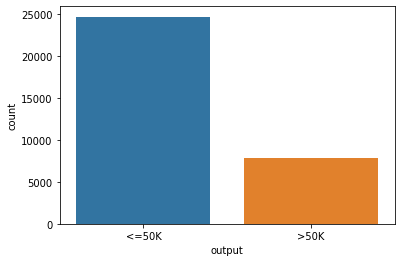

In [5]:
print((dataset.groupby('output').size() / dataset['output'].count()) * 100)

sns.countplot(x="output", data=dataset)
plt.show()

This distribution means that an algorithm that always predicts `<=50K` is right at ~76%, so if we can't do better there is no meaning in using ML for this particular problem.

In [6]:
condition = dataset.loc[:, "output"] == "<=50K"
dataset.loc[condition, "output"] = 0.0
dataset.loc[np.logical_not(condition), "output"] = 1.0

### Look for bad data
Aim here is to find bad data such as typos and correct them.

In [7]:
dataset.groupby(["race"])["race"].count()

race
Amer-Indian-Eskimo      311
Asian-Pac-Islander     1039
Black                  3124
Other                   271
White                 27527
Wite                    289
Name: race, dtype: int64

In [8]:
condition = dataset.loc[:, "race"] == "Wite"
dataset.loc[condition, "race"] = "White"
dataset.groupby(["race"])["race"].count()

race
Amer-Indian-Eskimo      311
Asian-Pac-Islander     1039
Black                  3124
Other                   271
White                 27816
Name: race, dtype: int64

Aggregate similar data to reduce feature dimension

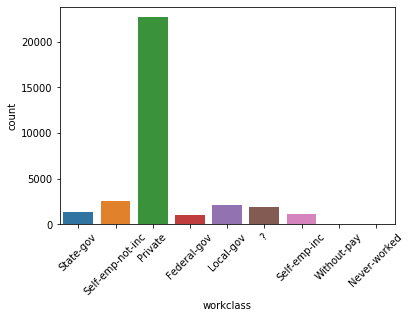

In [9]:
sns.countplot(x="workclass", data=dataset)
plt.xticks(rotation=45)
plt.show()

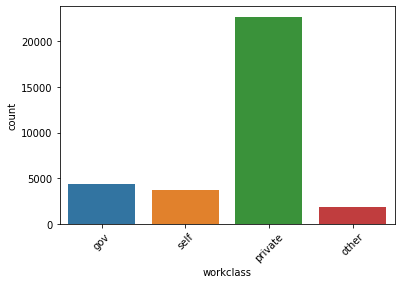

In [10]:
def replace_on_condition(dataset, column_name, condition_value, replace_value):
    condition = dataset.loc[:, column_name].str.contains(condition_value)
    dataset.loc[condition, column_name] = replace_value
    
    return dataset
    
dataset = replace_on_condition(dataset, "workclass", "Private", "private")
dataset = replace_on_condition(dataset, "workclass", "Self", "self")
dataset = replace_on_condition(dataset, "workclass", "gov", "gov")
dataset = replace_on_condition(dataset, "workclass", "Without", "other")
dataset = replace_on_condition(dataset, "workclass", "Never", "other")
dataset = replace_on_condition(dataset, "workclass", "\?", "other")

sns.countplot(x="workclass", data=dataset)
plt.xticks(rotation=45)
plt.show()

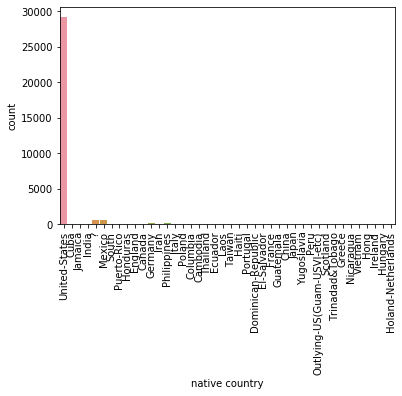

In [11]:
sns.countplot(x="native country", data=dataset)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


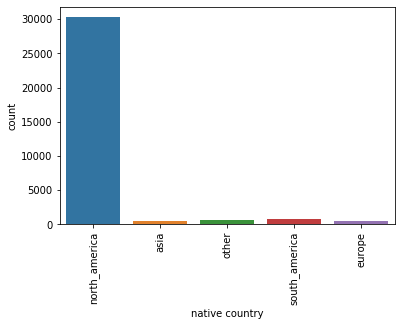

In [12]:
north_america = ['United-States', 'Cuba', 'Jamaica', 'Mexico', 'Honduras', 'Canada', 'Puerto-Rico', 'Outlying']
south_america = ['South', 'Philippines', 'Columbia', 'Cambodia', 'Ecuador', 'Haiti', 'Dominican-Republic', 'El-Salvador', 'Guatemala', 'Peru', 'Outlying-US(Guam-USVI-etc)', 'Trinadad&Tobago', 'Nicaragua']
asia = ['India', 'Iran', 'Thailand', 'Laos', 'Taiwan', 'China', 'Japan', 'Vietnam', 'Hong']
europe = ['England', 'Germany', 'Italy', 'Poland', 'Portugal', 'France', 'Yugoslavia', 'Scotland', 'Greece', 'Ireland', 'Hungary', 'Holand-Netherlands']
other = ['\?']

def replace_native_country(dataset, values, replacement):
    for value in values:
        dataset = replace_on_condition(dataset, "native country", value, replacement)
    
    return dataset

dataset = replace_native_country(dataset, north_america, "north_america")
dataset = replace_native_country(dataset, south_america, "south_america")
dataset = replace_native_country(dataset, asia, "asia")
dataset = replace_native_country(dataset, europe, "europe")
dataset = replace_native_country(dataset, other, "other")

sns.countplot(x="native country", data=dataset)
plt.xticks(rotation=90)
plt.show()

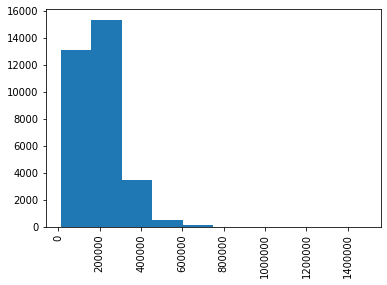

In [13]:
plt.xticks(rotation=90)
plt.hist(dataset["fnlwgt"])
plt.show()

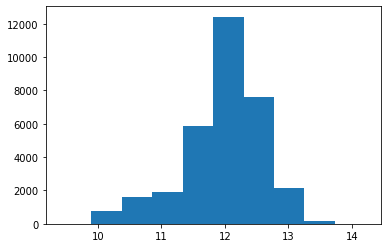

In [14]:
dataset["fnlwgt"] = np.log1p(dataset["fnlwgt"])

plt.hist(dataset["fnlwgt"])
plt.show()

### Standardization

We standardize numerical values to have all in the same range.

        age    fnlwgt  capital gain  capital loss  education num  hours/week
0  0.030670 -1.150280      0.148451     -0.216656       1.134721   -0.035429
1  0.837096 -1.035977     -0.145918     -0.216656       1.134721   -2.222119
2 -0.042641  0.471860     -0.145918     -0.216656      -0.420053   -0.035429
3  1.057031  0.606241     -0.145918     -0.216656      -1.197440   -0.035429
4 -0.775756  1.186286     -0.145918     -0.216656       1.134721   -0.035429


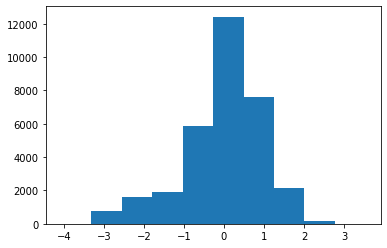

In [15]:
def standardize_number(dataframe, column_name):
    return (dataframe[column_name] - dataframe[column_name].mean()) / dataframe[column_name].std()

numerical_columns = ["age", "fnlwgt", "capital gain", "capital loss", "education num", "hours/week"]

for name in numerical_columns:
    dataset[name] = standardize_number(dataset, name)
    
print(dataset.loc[:, numerical_columns].head())

plt.hist(dataset["fnlwgt"])
plt.show()

### Expand categorical data
Aim here is to expand a categorical feature with finite values into more features.

In [16]:
def expand_category(dataframe, column_name):
    expanded_dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[column_name], prefix=column_name)], axis=1)

    expanded_dataframe.drop([column_name], axis=1, inplace=True)

    return expanded_dataframe

for name in ["workclass", "education", "marital status", "native country", "gender", "race", "occupation", "relationship"]:
    dataset = expand_category(dataset, name)

In [17]:
dataset.columns

Index(['age', 'fnlwgt', 'education num', 'capital gain', 'capital loss',
       'hours/week', 'output', 'workclass_gov', 'workclass_other',
       'workclass_private', 'workclass_self', 'education_10th',
       'education_11th', 'education_12th', 'education_1st-4th',
       'education_5th-6th', 'education_7th-8th', 'education_9th',
       'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital status_Divorced',
       'marital status_Married-AF-spouse', 'marital status_Married-civ-spouse',
       'marital status_Married-spouse-absent', 'marital status_Never-married',
       'marital status_Separated', 'marital status_Widowed',
       'native country_asia', 'native country_europe',
       'native country_north_america', 'native country_other',
       'native country_south_america', 'gender_Female', 'gender_

In [18]:
inputs = dataset.drop(["output"], axis=1).to_numpy(dtype=np.float32)
outputs = dataset["output"].to_numpy(dtype=np.float32)
outputs = np.expand_dims(outputs, 1)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

inputs, outputs = unison_shuffled_copies(inputs, outputs)

split_index = int(outputs.shape[0] * 0.1)

train_inputs = inputs[:split_index]
train_outputs = outputs[:split_index]
validation_inputs = inputs[split_index:]
validation_outputs = outputs[split_index:]

In [19]:
def build(output_size):
    model = models.Sequential()
    model.add(layers.GaussianNoise(0.1))
    model.add(layers.Dense(units=100, activation=activations.tanh))
    model.add(layers.Dense(units=output_size, activation=activations.sigmoid))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.0005))

    return model

def fit(epochs, batch_size, inputs, outputs, validation_inputs, validation_outputs):
    model.fit(inputs, outputs,
              callbacks=[callbacks.EarlyStopping(mode="min", patience=20, restore_best_weights=True, monitor="val_loss")],
              validation_data=(validation_inputs, validation_outputs),
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True)
    
epochs = 500
batch_size = 500

model = build(train_outputs.shape[1])

fit(epochs, batch_size, train_inputs, train_outputs, validation_inputs, validation_outputs)

Train on 3256 samples, validate on 29305 samples
Epoch 1/500
3256/3256 [==============================] - 1s 200us/sample - loss: 0.5935 - val_loss: 0.5419
Epoch 2/500
3256/3256 [==============================] - 0s 63us/sample - loss: 0.5154 - val_loss: 0.4878
Epoch 3/500
3256/3256 [==============================] - 0s 68us/sample - loss: 0.4701 - val_loss: 0.4540
Epoch 4/500
3256/3256 [==============================] - 0s 82us/sample - loss: 0.4399 - val_loss: 0.4303
Epoch 5/500
3256/3256 [==============================] - 0s 71us/sample - loss: 0.4180 - val_loss: 0.4123
Epoch 6/500
3256/3256 [==============================] - 0s 51us/sample - loss: 0.4020 - val_loss: 0.3984
Epoch 7/500
3256/3256 [==============================] - 0s 46us/sample - loss: 0.3893 - val_loss: 0.3878
Epoch 8/500
3256/3256 [==============================] - 0s 45us/sample - loss: 0.3765 - val_loss: 0.3798
Epoch 9/500
3256/3256 [==============================] - 0s 45us/sample - loss: 0.3711 - val_loss: 0.3

3256/3256 [==============================] - 0s 48us/sample - loss: 0.3133 - val_loss: 0.3268
Epoch 78/500
3256/3256 [==============================] - 0s 57us/sample - loss: 0.3133 - val_loss: 0.3266
Epoch 79/500
3256/3256 [==============================] - 0s 52us/sample - loss: 0.3126 - val_loss: 0.3264
Epoch 80/500
3256/3256 [==============================] - 0s 47us/sample - loss: 0.3085 - val_loss: 0.3263
Epoch 81/500
3256/3256 [==============================] - 0s 50us/sample - loss: 0.3141 - val_loss: 0.3263
Epoch 82/500
3256/3256 [==============================] - 0s 50us/sample - loss: 0.3102 - val_loss: 0.3263
Epoch 83/500
3256/3256 [==============================] - 0s 47us/sample - loss: 0.3098 - val_loss: 0.3264
Epoch 84/500
3256/3256 [==============================] - 0s 63us/sample - loss: 0.3160 - val_loss: 0.3263
Epoch 85/500
3256/3256 [==============================] - 0s 67us/sample - loss: 0.3113 - val_loss: 0.3262
Epoch 86/500
3256/3256 [==========================

3256/3256 [==============================] - 0s 48us/sample - loss: 0.3058 - val_loss: 0.3244
Epoch 154/500
3256/3256 [==============================] - 0s 55us/sample - loss: 0.3010 - val_loss: 0.3243
Epoch 155/500
3256/3256 [==============================] - 0s 53us/sample - loss: 0.3072 - val_loss: 0.3242
Epoch 156/500
3256/3256 [==============================] - 0s 56us/sample - loss: 0.3030 - val_loss: 0.3241
Epoch 157/500
3256/3256 [==============================] - 0s 50us/sample - loss: 0.3002 - val_loss: 0.3242
Epoch 158/500
3256/3256 [==============================] - 0s 50us/sample - loss: 0.3073 - val_loss: 0.3243
Epoch 159/500
3256/3256 [==============================] - 0s 52us/sample - loss: 0.3077 - val_loss: 0.3245
Epoch 160/500
3256/3256 [==============================] - 0s 52us/sample - loss: 0.3072 - val_loss: 0.3243
Epoch 161/500
3256/3256 [==============================] - 0s 51us/sample - loss: 0.3032 - val_loss: 0.3243
Epoch 162/500
3256/3256 [=================

In [20]:
def predict_and_plot(n, inputs, outputs):
    selection = np.arange(n)

    predicted = model.predict(inputs)[selection]

    absolute_distance_from_outputs = np.abs(outputs[selection] - predicted)
    missclassified_number = np.sum((absolute_distance_from_outputs > 0.5) * 1.0)
    
    plt.figure(figsize=(20,3))
    plt.plot(np.zeros(n), 'b')
    plt.plot(np.ones(n) * 0.5, 'b')
    plt.plot(np.ones(n), 'b')
    plt.plot(absolute_distance_from_outputs, 'xr')
    
    print(str(missclassified_number / n * 100) + "%")
    plt.show()

13.0%


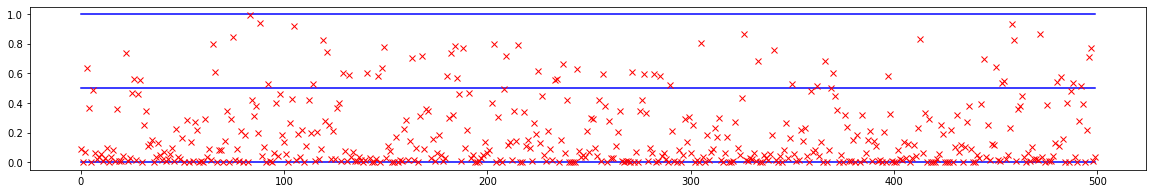

In [21]:
predict_and_plot(500, train_inputs, train_outputs)

13.600000000000001%


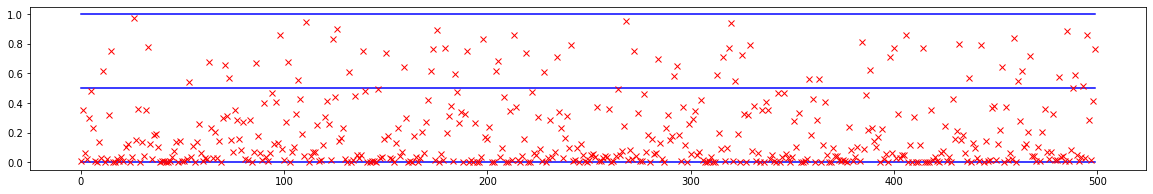

In [22]:
predict_and_plot(500, validation_inputs, validation_outputs)